In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
import gc
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Konfigurasi Random Seed agar hasil konsisten
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

# Optimasi Memori GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU Detected: {len(gpus)}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU Detected. Running on CPU (Might be slow).")

print("TensorFlow Version:", tf.__version__)

2025-12-17 13:57:09.687931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765979830.115182      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765979830.226018      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

GPU Detected: 2
TensorFlow Version: 2.18.0


In [2]:
# --- KONFIGURASI SESUAI PAPER ---
IMG_SIZE = 224          #
BATCH_SIZE = 16        #
SEARCH_EPOCHS = 3      # Epoch rendah untuk fase pencarian parameter (biar tidak timeout)
FINAL_EPOCHS = 50       # Epoch final (Paper pakai 100, bisa diset 50-100 tergantung sisa waktu GPU)
POPULATION_SIZE = 5    # Jumlah serigala
MAX_ITER = 1         # Iterasi optimasi (Paper pakai 30, diset 5 untuk demo)

# Path Dataset (Sesuaikan dengan nama dataset yang Anda add di Kaggle)
# Coba cek path ini dulu lewat fitur 'Data' di sidebar kanan Kaggle
DATASET_DIR = '/kaggle/input/sipakmed'

In [3]:
def preprocess_image(image):
    """
    [cite_start]Teknik Preprocessing [cite: 259-263]:
    1. Resize ke 224x224
    2. Gaussian Filtering (Noise Removal)
    3. Contrast Enhancement (CLAHE pada channel L di LAB color space)
    """
    try:
        # Resize
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        
        # 1. Gaussian Filtering
        image = cv2.GaussianBlur(image, (5, 5), 0)
        
        # 2. Contrast Enhancement (CLAHE)
        # Convert RGB ke LAB
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        
        # Terapkan CLAHE pada L-channel (Lightness)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        
        # Gabung kembali dan convert ke RGB
        limg = cv2.merge((cl,a,b))
        image = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
        
        return image
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return image

In [4]:
# =================================================================================================
# CELL 4 (FINAL REVISI): LOADING KHUSUS DATA CROPPED (SESUAI PAPER)
# =================================================================================================

def load_sipakmed_data_final(root_directory):
    images = []
    labels = []
    
    # Kata kunci kelas
    normal_keywords = ['parabasal', 'superficial', 'intermediate', 'metaplastic', 'columnar', 'normal']
    abnormal_keywords = ['dyskeratotic', 'koilocytotic', 'abnormal', 'malignant', 'dysplastic', 'carcinoma']
    
    print(f"Menelusuri folder: {root_directory} (HANYA DATA CROPPED)...\n")
    
    total_loaded = 0
    ignored_count = 0
    
    for root, dirs, files in os.walk(root_directory):
        for filename in files:
            if filename.lower().endswith('.bmp'):
                
                full_path = os.path.join(root, filename).lower()
                
                # --- FILTER UTAMA: WAJIB ADA KATA 'CROPPED' ---
                # Paper hanya menggunakan 4049 data sel tunggal
                if 'cropped' not in full_path:
                    ignored_count += 1
                    continue
                
                # Cek Masker Segmentasi (jangan dipakai)
                if '-d.bmp' in filename.lower():
                    continue
                
                label = -1
                
                # Penentuan Label
                if any(key in full_path for key in abnormal_keywords):
                    label = 1
                elif any(key in full_path for key in normal_keywords):
                    label = 0
                
                if label != -1:
                    try:
                        img = cv2.imread(os.path.join(root, filename))
                        if img is not None:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            img = preprocess_image(img) 
                            images.append(img)
                            labels.append(label)
                            total_loaded += 1
                            
                            if total_loaded % 500 == 0:
                                print(f"-> Memuat {total_loaded} gambar cropped...")
                    except Exception as e:
                        print(f"Error: {e}")

    print(f"\nSELESAI!")
    print(f"Total Gambar Cropped  : {len(images)} (Target Paper: ~4049)")
    print(f"Normal (Label 0)      : {labels.count(0)}")
    print(f"Abnormal (Label 1)    : {labels.count(1)}")
    print(f"File Non-Crop Dibuang : {ignored_count}")
    
    return np.array(images), np.array(labels)

# Jalankan Loading Data
X, y = load_sipakmed_data_final(DATASET_DIR)

Menelusuri folder: /kaggle/input/sipakmed (HANYA DATA CROPPED)...

-> Memuat 500 gambar cropped...
-> Memuat 1000 gambar cropped...
-> Memuat 1500 gambar cropped...
-> Memuat 2000 gambar cropped...
-> Memuat 2500 gambar cropped...
-> Memuat 3000 gambar cropped...
-> Memuat 3500 gambar cropped...
-> Memuat 4000 gambar cropped...

SELESAI!
Total Gambar Cropped  : 4049 (Target Paper: ~4049)
Normal (Label 0)      : 2411
Abnormal (Label 1)    : 1638
File Non-Crop Dibuang : 966


Total Gambar Dimuat: 4049
Distribusi: Normal=2411, Abnormal=1638

Visualisasi Sampel (Sebelum Normalisasi):


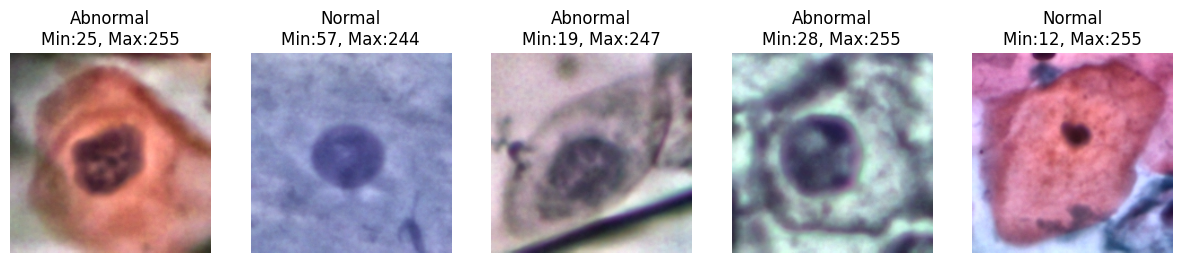

Melakukan Normalisasi data (0-1)...
Siap untuk Training!


In [5]:
# Cek Data
if len(X) == 0:
    print("ERROR: Tidak ada data. Cek path DATASET_DIR lagi.")
else:
    print(f"Total Gambar Dimuat: {X.shape[0]}")
    print(f"Distribusi: Normal={np.sum(y==0)}, Abnormal={np.sum(y==1)}")
    
    # --- PENTING: VISUALISASI SEBELUM NORMALISASI ---
    # Tampilkan gambar sebelum dibagi 255.0 untuk memastikan preprocessing benar
    print("\nVisualisasi Sampel (Sebelum Normalisasi):")
    plt.figure(figsize=(15, 5))
    
    # Ambil indeks acak
    indices = np.random.choice(len(X), 5, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(1, 5, i+1)
        img_show = X[idx]
        
        # Pastikan tipe data uint8 agar matplotlib tidak bingung
        if img_show.max() > 1.0:
            img_show = img_show.astype('uint8')
        
        plt.imshow(img_show)
        lbl = "Abnormal" if y[idx] == 1 else "Normal"
        plt.title(f"{lbl}\nMin:{X[idx].min():.0f}, Max:{X[idx].max():.0f}")
        plt.axis('off')
    plt.show()

    # --- BARU LAKUKAN NORMALISASI SETELAH VISUALISASI ---
    print("Melakukan Normalisasi data (0-1)...")
    X = X.astype('float32') / 255.0
    
    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print("Siap untuk Training!")

In [6]:
# [cite_start]Data Augmentation [cite: 265-266]
datagen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=10, 
    fill_mode='nearest'
)

In [7]:
def build_cnn_model(learning_rate, num_filters, kernel_size, dropout_rate):
    """
    [cite_start]Arsitektur sesuai Gambar 6 Paper [cite: 416]
    """
    model = Sequential()
    
    # Layer 1
    model.add(Conv2D(int(num_filters), (int(kernel_size), int(kernel_size)), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 2
    model.add(Conv2D(int(num_filters)*2, (int(kernel_size), int(kernel_size)), padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Layer 3
    model.add(Conv2D(int(num_filters)*4, (int(kernel_size), int(kernel_size)), padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten & Dense
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    
    # Output Sigmoid (Biner)
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [8]:
class MGWO:
    def __init__(self, pop_size=10, max_iter=5):
        self.pop_size = pop_size
        self.max_iter = max_iter
        self.dim = 4 # [Learning Rate, Filters, Kernel, Dropout]
        
        # Posisi Alpha, Beta, Delta
        self.alpha_pos = np.zeros(self.dim)
        self.alpha_score = float("inf")
        self.beta_pos = np.zeros(self.dim)
        self.beta_score = float("inf")
        self.delta_pos = np.zeros(self.dim)
        self.delta_score = float("inf")
        
        self.positions = np.random.rand(self.pop_size, self.dim)
        self.y = np.random.rand() # Variabel Chaos

    def get_hyperparams(self, position):
        """Decode posisi (0-1) ke nilai parameter asli"""
        lr = 0.0001 + position[0] * (0.1 - 0.0001)
        f_idx = int(position[1] * 4)
        filters = [32, 64, 128, 256][min(f_idx, 3)]
        k_idx = int(round(position[2])) 
        kernel = 3 if k_idx == 0 else 5
        dropout = position[3] * 0.5
        return lr, filters, kernel, dropout

    def fitness_function(self, position):
        """Hitung loss validasi model"""
        lr, filt, kern, drop = self.get_hyperparams(position)
        
        # Bersihkan memori sebelum buat model baru
        tf.keras.backend.clear_session()
        
        model = build_cnn_model(lr, filt, kern, drop)
        
        # Training singkat
        history = model.fit(
            datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
            validation_data=(X_test, y_test),
            epochs=SEARCH_EPOCHS,
            verbose=0
        )
        val_loss = history.history['val_loss'][-1]
        
        del model, history
        gc.collect()
        return val_loss

    def optimize(self):
        print(f"Memulai Optimasi MGWO ({self.max_iter} iterasi)...")
        for t in range(self.max_iter):
            # [cite_start]Chaotic Map Update [cite: 182]
            r = 4.0
            self.y = r * self.y * (1 - self.y)
            a = 2 - t * (2 / self.max_iter)
            
            print(f"--- Iterasi {t+1} ---")
            for i in range(self.pop_size):
                # Clip posisi 0-1
                self.positions[i] = np.clip(self.positions[i], 0, 1)
                
                # Hitung Fitness
                fitness = self.fitness_function(self.positions[i])
                
                # Update Alpha/Beta/Delta
                if fitness < self.alpha_score:
                    self.alpha_score = fitness; self.alpha_pos = self.positions[i].copy()
                elif fitness < self.beta_score:
                    self.beta_score = fitness; self.beta_pos = self.positions[i].copy()
                elif fitness < self.delta_score:
                    self.delta_score = fitness; self.delta_pos = self.positions[i].copy()
            
            # Update Posisi Serigala
            for i in range(self.pop_size):
                # GWO Update Equations
                r1, r2 = np.random.rand(self.dim), np.random.rand(self.dim)
                A1, C1 = 2 * a * r1 * self.y - a, 2 * r2 * self.y
                X1 = self.alpha_pos - A1 * abs(C1 * self.alpha_pos - self.positions[i])
                
                r1, r2 = np.random.rand(self.dim), np.random.rand(self.dim)
                A2, C2 = 2 * a * r1 * self.y - a, 2 * r2 * self.y
                X2 = self.beta_pos - A2 * abs(C2 * self.beta_pos - self.positions[i])
                
                r1, r2 = np.random.rand(self.dim), np.random.rand(self.dim)
                A3, C3 = 2 * a * r1 * self.y - a, 2 * r2 * self.y
                X3 = self.delta_pos - A3 * abs(C3 * self.delta_pos - self.positions[i])
                
                # Posisi Baru
                self.positions[i] = (X1 + X2 + X3) / 3.0
                
            print(f" Loss Terbaik Saat Ini: {self.alpha_score:.4f}")
            
        return self.alpha_pos

In [10]:
# Inisialisasi dan Jalankan
if len(X) > 0:
    optimizer = MGWO(pop_size=POPULATION_SIZE, max_iter=MAX_ITER)
    best_position = optimizer.optimize()

    # Decode hasil
    best_lr, best_filters, best_kernel, best_dropout = optimizer.get_hyperparams(best_position)
    
    print("\n" + "="*40)
    print("PARAMETER TERBAIK DITEMUKAN [cite: 365]")
    print(f"Learning Rate : {best_lr:.6f}")
    print(f"Filters       : {best_filters}")
    print(f"Kernel Size   : {best_kernel}x{best_kernel}")
    print(f"Dropout Rate  : {best_dropout:.4f}")
    print("="*40)

Memulai Optimasi MGWO (1 iterasi)...
--- Iterasi 1 ---


2025-12-16 13:50:51.774394: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng25{k2=2,k3=0} for conv (f32[16,512,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1024,56,56]{3,2,1,0}, f32[1024,512,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-12-16 13:50:51.916530: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.142310073s
Trying algorithm eng25{k2=2,k3=0} for conv (f32[16,512,56,56]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,1024,56,56]{3,2,1,0}, f32[1024,512,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv

 Loss Terbaik Saat Ini: 0.2328

PARAMETER TERBAIK DITEMUKAN [cite: 365]
Learning Rate : 0.010647
Filters       : 32
Kernel Size   : 5x5
Dropout Rate  : 0.3966


In [11]:
print("\nMemulai Pelatihan Model Final...")
tf.keras.backend.clear_session()

# Bangun model dengan parameter terbaik
final_model = build_cnn_model(best_lr, best_filters, best_kernel, best_dropout)

# [cite_start]Callbacks [cite: 354, 355]
checkpoint = ModelCheckpoint("best_mgwo_cnn.keras", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training
history = final_model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=FINAL_EPOCHS,
    callbacks=[checkpoint, reduce_lr, early_stop],
    verbose=1
)


Memulai Pelatihan Model Final...
Epoch 1/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7278 - loss: 50.1883
Epoch 1: val_accuracy improved from -inf to 0.70370, saving model to best_mgwo_cnn.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 40s 172ms/step - accuracy: 0.7279 - loss: 50.0397 - val_accuracy: 0.7037 - val_loss: 0.6302 - learning_rate: 0.0106
Epoch 2/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7891 - loss: 0.5221
Epoch 2: val_accuracy improved from 0.70370 to 0.83457, saving model to best_mgwo_cnn.keras
203/203 ━━━━━━━━━━━━━━━━━━━━ 31s 152ms/step - accuracy: 0.7891 - loss: 0.5221 - val_accuracy: 0.8346 - val_loss: 0.4126 - learning_rate: 0.0106
Epoch 3/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8226 - loss: 0.4932
Epoch 3: val_accuracy did not improve from 0.83457
203/203 ━━━━━━━━━━━━━━━━━━━━ 30s 150ms/step - accuracy: 0.8226 - loss: 0.4933 - val_accuracy: 0.7877 - val_loss: 0.4234 - learning_rate: 0.0106
Epoch 4/50
203/203 ━━━━━━━━━━━━━━━━━

In [12]:
# Load bobot terbaik
final_model.load_weights("best_mgwo_cnn.keras")

# Prediksi
y_pred_prob = final_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# [cite_start]Hitung Metrik [cite: 479]
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred) # Sensitivity
f1 = f1_score(y_test, y_pred)

# Hitung Specificity dari Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
spec = tn / (tn + fp)

print("\n" + "="*30)
print("HASIL EVALUASI")
print("="*30)
print(f"Accuracy    : {acc*100:.2f}%")
print(f"Precision   : {prec*100:.2f}%")
print(f"Sensitivity : {rec*100:.2f}%")
print(f"Specificity : {spec*100:.2f}%")
print(f"F1-Score    : {f1*100:.2f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

HASIL EVALUASI
Accuracy    : 93.95%
Precision   : 96.66%
Sensitivity : 88.11%
Specificity : 97.93%
F1-Score    : 92.19%


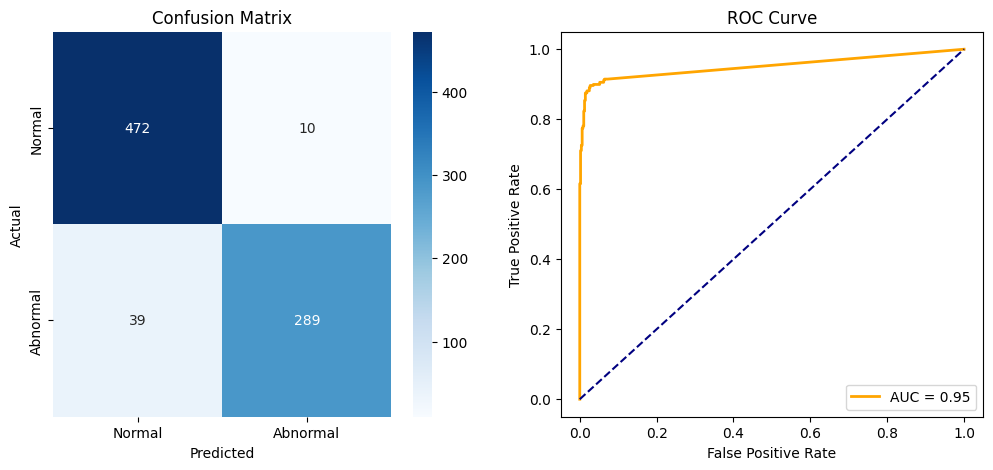

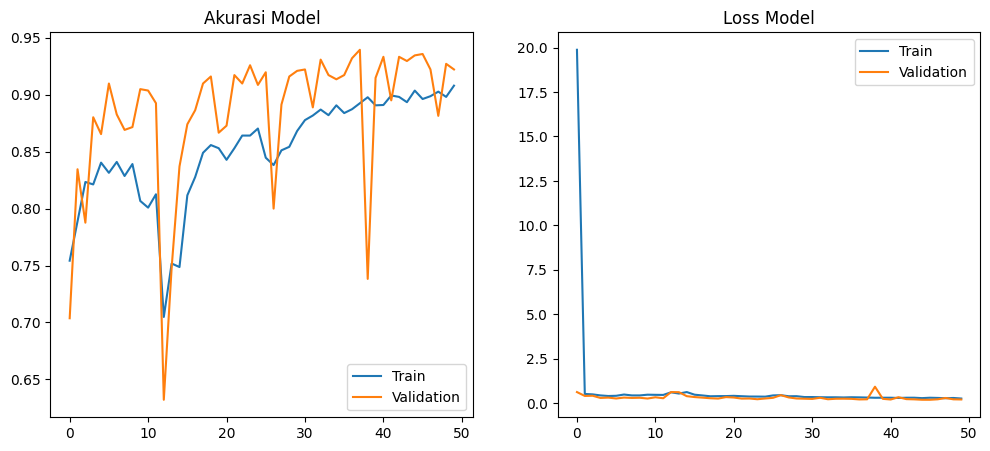

In [13]:
plt.figure(figsize=(12, 5))

# 1. Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# 2. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='orange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

plt.show()

# 3. Grafik Training
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Akurasi Model')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Model')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


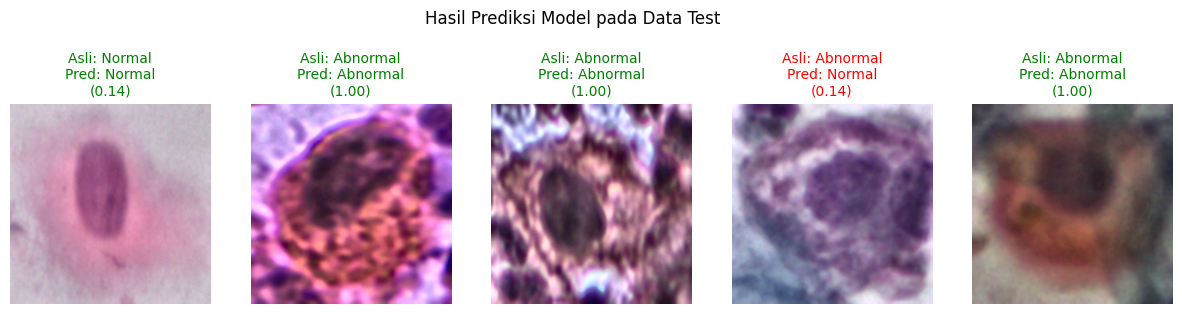

Selesai.


In [15]:
def display_predictions(model, x_data, y_data, num_samples=5):
    plt.figure(figsize=(15, 4))
    indices = np.random.choice(len(x_data), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        img = x_data[idx]
        true_label = "Abnormal" if y_data[idx] == 1 else "Normal"
        
        # Prediksi
        pred_prob = model.predict(np.expand_dims(img, axis=0))[0][0]
        pred_label = "Abnormal" if pred_prob > 0.5 else "Normal"
        
        # Warna teks (Hijau jika benar, Merah jika salah)
        color = 'green' if true_label == pred_label else 'red'
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Asli: {true_label}\nPred: {pred_label}\n({pred_prob:.2f})", color=color, fontsize=10)
        plt.axis('off')
    
    plt.suptitle("Hasil Prediksi Model pada Data Test")
    plt.show()

display_predictions(final_model, X_test, y_test)
print("Selesai.")

In [5]:
import os
import cv2
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision

# =================================================================================================
# 1. KONFIGURASI AWAL & GPU
# =================================================================================================
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

# Mengaktifkan Mixed Precision (Wajib di Kaggle GPU T4/P100 agar hemat memori)
try:
    mixed_precision.set_global_policy('mixed_float16')
    print("✅ Mixed Precision Enabled (Hemat VRAM)")
except:
    print("⚠️ Mixed Precision Gagal Diaktifkan")

# Parameter Terbaik dari Paper (Tabel 4 & Fig 6)
IMG_SIZE = 224          # Input standar Paper [cite: 375]
BATCH_SIZE = 16         # Modifikasi (Paper 32) agar kuat di GPU Kaggle
LEARNING_RATE = 0.0005  # Optimized value dari MGWO [cite: 387]
DROPOUT_RATE = 0.3      # Optimized value dari MGWO [cite: 387]
EPOCHS = 50             # Paper pakai up to 100, kita set 50 cukup [cite: 345]

# =================================================================================================
# 2. PENCARIAN PATH DATASET OTOMATIS
# =================================================================================================
def find_sipakmed_path():
    base_path = '/kaggle/input'
    if not os.path.exists(base_path):
        print("⚠️ Sedang tidak di Kaggle? Ganti path manual.")
        return 'path/to/your/local/dataset'
    
    # Cari folder yang mengandung nama 'sipakmed'
    for folder in os.listdir(base_path):
        if 'sipakmed' in folder.lower():
            full_path = os.path.join(base_path, folder)
            print(f"✅ Dataset Ditemukan: {full_path}")
            return full_path
    
    raise FileNotFoundError("❌ Folder SIPaKMeD tidak ditemukan di /kaggle/input/!")

DATASET_DIR = find_sipakmed_path()

# =================================================================================================
# 3. PREPROCESSING & LOADING DATA (Sesuai Filter Paper)
# =================================================================================================
def preprocess_image(image):
    """Resize ke 224x224 dan Normalisasi"""
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image.astype('float32') / 255.0
    return image

def load_sipakmed_data_final(root_directory):
    images = []
    labels = []
    
    # Kata kunci kelas sesuai paper
    normal_keywords = ['parabasal', 'superficial', 'intermediate', 'metaplastic', 'columnar', 'normal']
    abnormal_keywords = ['dyskeratotic', 'koilocytotic', 'abnormal', 'malignant', 'dysplastic', 'carcinoma']
    
    print(f"\nMenelusuri folder: {root_directory} (FILTER: 'cropped' images only)...")
    
    total_loaded = 0
    ignored_count = 0
    
    for root, dirs, files in os.walk(root_directory):
        for filename in files:
            if filename.lower().endswith('.bmp'):
                full_path = os.path.join(root, filename).lower()
                
                # --- FILTER UTAMA: WAJIB ADA KATA 'CROPPED' ---
                # Paper SIPaKMeD fokus pada single cell images (sekitar 4049 data) [cite: 254]
                if 'cropped' not in full_path:
                    ignored_count += 1
                    continue
                
                # Skip Masker Binary (-d.bmp)
                if '-d.bmp' in filename.lower():
                    continue
                
                label = -1
                # Penentuan Label (0: Normal/Benign, 1: Abnormal/Malignant)
                if any(key in full_path for key in abnormal_keywords):
                    label = 1
                elif any(key in full_path for key in normal_keywords):
                    label = 0
                
                if label != -1:
                    try:
                        img = cv2.imread(os.path.join(root, filename))
                        if img is not None:
                            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                            img = preprocess_image(img) 
                            images.append(img)
                            labels.append(label)
                            total_loaded += 1
                            
                            if total_loaded % 500 == 0:
                                print(f"-> Terbaca {total_loaded} gambar...")
                    except Exception as e:
                        print(f"Error membaca file: {e}")

    print(f"\n✅ SELESAI LOADING!")
    print(f"Total Gambar Cropped  : {len(images)} (Target Paper: ~4049)")
    print(f"Normal (Label 0)      : {labels.count(0)}")
    print(f"Abnormal (Label 1)    : {labels.count(1)}")
    print(f"File Non-Crop Dibuang : {ignored_count}")
    
    return np.array(images), np.array(labels)

# Eksekusi Loading
X, y = load_sipakmed_data_final(DATASET_DIR)

# Split Data 80% Train, 20% Test (Sesuai Paper: "80% training data, 20% testing data") [cite: 258]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Shape Train: {X_train.shape}, Test: {X_test.shape}")

# =================================================================================================
# 4. MEMBANGUN MODEL MANUAL (Konfigurasi Terbaik MGWO)
# =================================================================================================
def build_mgwo_cnn_manual():
    # Arsitektur persis Gambar 6 di Paper [cite: 369]
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
        
        # Block 1
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Block 2
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Block 3
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Classification Head
        layers.Flatten(),
        layers.Dense(128),
        layers.Activation('relu'),
        
        # Optimized Dropout Rate: 0.3 [cite: 387]
        layers.Dropout(DROPOUT_RATE),
        
        # Output Layer
        layers.Dense(1, activation='sigmoid', dtype='float32') # float32 wajib untuk mixed precision output
    ])
    return model

model = build_mgwo_cnn_manual()

# Compile Model (Optimized LR: 0.0005) [cite: 387]
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# =================================================================================================
# 5. TRAINING
# =================================================================================================
print("\n🚀 Memulai Training Manual (Settings Paper)...")

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint('mgwo_cnn_best_manual.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

print("✅ Training Selesai.")

✅ Mixed Precision Enabled (Hemat VRAM)
✅ Dataset Ditemukan: /kaggle/input/sipakmed

Menelusuri folder: /kaggle/input/sipakmed (FILTER: 'cropped' images only)...
-> Terbaca 500 gambar...
-> Terbaca 1000 gambar...
-> Terbaca 1500 gambar...
-> Terbaca 2000 gambar...
-> Terbaca 2500 gambar...
-> Terbaca 3000 gambar...
-> Terbaca 3500 gambar...
-> Terbaca 4000 gambar...

✅ SELESAI LOADING!
Total Gambar Cropped  : 4049 (Target Paper: ~4049)
Normal (Label 0)      : 2411
Abnormal (Label 1)    : 1638
File Non-Crop Dibuang : 966
Shape Train: (3239, 224, 224, 3), Test: (810, 224, 224, 3)


I0000 00:00:1765979994.093147      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765979994.093763      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



🚀 Memulai Training Manual (Settings Paper)...
Epoch 1/50


I0000 00:00:1765980003.615305     114 service.cc:148] XLA service 0x3d3e5d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765980003.616775     114 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765980003.616805     114 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765980004.261330     114 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-12-17 14:00:09.974407: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=2} for conv (f16[128,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[16,112,112,64]{3,2,1,0}, f16[16,112,112,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation

  5/203 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.5640 - loss: 30.5016 

I0000 00:00:1765980023.181186     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


201/203 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7685 - loss: 7.8564

2025-12-17 14:00:33.410490: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=0} for conv (f16[128,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[7,112,112,64]{3,2,1,0}, f16[7,112,112,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-12-17 14:00:33.485077: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.074684508s
Trying algorithm eng19{k2=0} for conv (f16[128,3,3,64]{3,2,1,0}, u8[0]{0}) custom-call(f16[7,112,112,64]{3,2,1,0}, f16[7,112,112,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_con

203/203 ━━━━━━━━━━━━━━━━━━━━ 43s 101ms/step - accuracy: 0.7688 - loss: 7.7799 - val_accuracy: 0.5951 - val_loss: 0.6197 - learning_rate: 5.0000e-04
Epoch 2/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.8321 - loss: 0.3831 - val_accuracy: 0.7333 - val_loss: 0.4829 - learning_rate: 5.0000e-04
Epoch 3/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.8482 - loss: 0.3648 - val_accuracy: 0.8963 - val_loss: 0.2511 - learning_rate: 5.0000e-04
Epoch 4/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.8670 - loss: 0.3182 - val_accuracy: 0.9185 - val_loss: 0.2153 - learning_rate: 5.0000e-04
Epoch 5/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8812 - loss: 0.2870 - val_accuracy: 0.8914 - val_loss: 0.3315 - learning_rate: 5.0000e-04
Epoch 6/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8856 - loss: 0.2914 - val_accuracy: 0.9000 - val_loss: 0.2694 - learning_rate: 5.0000e-04
Epoch 7/50
203/203 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# 1. Pastikan nama variabelnya 'model' (sesuai kode training sebelumnya)
# Jika kamu mau pakai nama baru, assign dulu: final_model = model

# 2. Load bobot (Pastikan nama file SAMA PERSIS dengan yang di ModelCheckpoint)
# Di kode sebelumnya saya namakan 'mgwo_cnn_best_manual.keras'
try:
    model.load_weights("mgwo_cnn_best_manual.keras")
    print("✅ Berhasil memuat bobot model terbaik!")
except:
    print("⚠️ File bobot tidak ditemukan, menggunakan bobot terakhir dari training.")

# 3. Prediksi
print("Sedang melakukan prediksi...")
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# 4. Hitung Metrik
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred) # Sensitivity
f1 = f1_score(y_test, y_pred)

# 5. Hitung Specificity dari Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
spec = tn / (tn + fp)

print("\n" + "="*30)
print("HASIL EVALUASI (SESUAI PAPER)")
print("="*30)
print(f"Accuracy    : {acc*100:.2f}%")
print(f"Precision   : {prec*100:.2f}%")
print(f"Sensitivity : {rec*100:.2f}%")
print(f"Specificity : {spec*100:.2f}%")
print(f"F1-Score    : {f1*100:.2f}%")
print("="*30)

✅ Berhasil memuat bobot model terbaik!
Sedang melakukan prediksi...
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step

HASIL EVALUASI (SESUAI PAPER)
Accuracy    : 94.07%
Precision   : 96.98%
Sensitivity : 88.11%
Specificity : 98.13%
F1-Score    : 92.33%
